In [1]:
!pip install -q --upgrade accelerate transformers datasets

In [2]:
!pip install bitsandbytes

In [3]:
!pip install -q nltk

In [4]:
from transformers import AutoModelForCausalLM, AutoTokenizer, BitsAndBytesConfig
from datasets import load_dataset
import pandas as pd
import string
import os
import nltk
nltk.download('stopwords')
from nltk.corpus import stopwords

dataset = load_dataset("liar")
df = pd.DataFrame(dataset['train'])
df = df.rename(columns={'label': 'label', 'statement': 'statement'})
unique_labels = df['label'].unique()
print("Unique labels:", unique_labels)

# Preprocess the statements: removing punctuation
df['statement'] = df['statement'].apply(lambda x: x.translate(str.maketrans('', '', string.punctuation)))
print(df.head(3))

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:88: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


Unique labels: [0 1 2 3 4 5]
           id  label                                          statement  \
0   2635.json      0  Says the Annies List political group supports ...   
1  10540.json      1  When did the decline of coal start It started ...   
2    324.json      2  Hillary Clinton agrees with John McCain by vot...   

                              subject         speaker             job_title  \
0                            abortion    dwayne-bohac  State representative   
1  energy,history,job-accomplishments  scott-surovell        State delegate   
2                      foreign-policy    barack-obama             President   

  state_info party_affiliation  barely_true_counts  false_counts  \
0      Texas        republican                 0.0           1.0   
1   Virginia          democrat                 0.0           0.0   
2   Illinois          democrat                70.0          71.0   

   half_true_counts  mostly_true_counts  pants_on_fire_counts          context  

In [5]:
from huggingface_hub import notebook_login
notebook_login()

In [7]:
from accelerate import init_empty_weights
from accelerate.utils import load_and_quantize_model, BnbQuantizationConfig
from accelerate import Accelerator
import torch
from transformers import AutoModelForCausalLM, AutoTokenizer, BitsAndBytesConfig

### Surprisal Values ###
model_name = 'google/gemma-2b'

bnb_config = BitsAndBytesConfig(
    load_in_4bit=True,
    bnb_4bit_use_double_quant=True,
    bnb_4bit_quant_type="nf4",
    bnb_4bit_compute_dtype=torch.bfloat16,
)
#gemma_model = AutoModelForCausalLM.from_pretrained(model_name)
gemma_model = AutoModelForCausalLM.from_pretrained(model_name, quantization_config=bnb_config)
gemma_tokenizer = AutoTokenizer.from_pretrained(model_name)

def compute_surprisal(statement):
    tokenize_input = gemma_tokenizer.tokenize(statement)
    tensor_input = torch.tensor([gemma_tokenizer.convert_tokens_to_ids(tokenize_input)])
    with torch.no_grad():
        outputs = gemma_model(tensor_input, labels=tensor_input)
    loss, logits = outputs[:2]
    return loss.item()  # The loss is the negative log likelihood

def extract_surprisal_values(statement):
    words = statement.split()
    surprisal_values = []
    for i in range(1, len(words) + 1):
        sub_statement = ' '.join(words[:i])
        surprisal = compute_surprisal(sub_statement)
        surprisal_values.append(surprisal)
    return surprisal_values

`low_cpu_mem_usage` was None, now set to True since model is quantized.


Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

In [8]:
max_len = 0

# Iterate over the statements in your dataset
for statement in df['statement']:
    # Tokenize the statement
    tokens = gemma_tokenizer.tokenize(statement)

    # Update max_len if the current sequence is longer
    max_len = max(max_len, len(tokens))

print(f"The longest sequence has {max_len} tokens.")

The longest sequence has 87 tokens.


In [ ]:
statement = "The movie was fantastic and thrilling."

#sentiment_score = extract_sentiment_scores(statement)
#print(f"Sentiment score (1-5): {sentiment_score}")

surprisal_values = extract_surprisal_values(statement)
print(f"Surprisal values: {surprisal_values}")

In [9]:
import torch
from torch import nn
from torch.utils.data import DataLoader, TensorDataset
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
from transformers import AutoModelForCausalLM, AutoTokenizer
import pandas as pd
import string
import numpy as np
from tqdm import tqdm
import torch.optim as optim
from torch.nn.utils.rnn import pad_sequence

In [10]:
 # Check available GPU devices and print out their names
if torch.cuda.is_available():
    for i in range(torch.cuda.device_count()):
        print(f"Device {i}: {torch.cuda.get_device_name(i)}")
    device = torch.device("cuda:0")  # Assuming you use the first GPU if available
else:
    device = torch.device("cpu")

print(f'Using device: {device}')

Device 0: Tesla T4
Using device: cuda:0


In [ ]:
import os
os.environ['CUDA_LAUNCH_BLOCKING'] = "1"


In [11]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f'Using device: {device}')

max_length_1 = 87

def generate_features(statement, device):
    # Tokenize the statement and ensure the input is on the correct device
    #inputs = gemma_tokenizer(statement, return_tensors="pt", max_length=max_length, truncation=True, pad_to_max_length=True)
    inputs = gemma_tokenizer(statement, return_tensors="pt", max_length=max_length_1, truncation=True, pad_to_max_length=False)
    inputs = inputs.to(device)

    with torch.no_grad():
        outputs = gemma_model(**inputs, output_hidden_states=True)

    # Extract embeddings and ensure they are on the correct device
    embeddings = outputs.hidden_states[-1].squeeze(0).to(device) #  the last layer's hidden states, which are typically used as the token embeddings.

    surprisal_values = []
    for i in range(1, len(inputs['input_ids'][0])):
        sub_input = inputs['input_ids'][:, :i + 1].to(device)
        sub_labels = sub_input.clone().to(device)

        with torch.no_grad():
            outputs = gemma_model(sub_input, labels=sub_labels)

        loss = outputs.loss
        surprisal_values.append(loss.item())

    # Ensure surprisal_values length matches embeddings' sequence length
    surprisal_values += [0] * (embeddings.size(0) - len(surprisal_values))

    # Create a tensor for surprisal values and ensure it's on the correct device
    surprisal_tensor = torch.tensor(surprisal_values, device=device).unsqueeze(1)

    # Ensure the surprisal_tensor is the same length as embeddings
    if surprisal_tensor.size(0) < embeddings.size(0):
        padding = torch.zeros((embeddings.size(0) - surprisal_tensor.size(0), 1), device=device)
        surprisal_tensor = torch.cat((surprisal_tensor, padding), dim=0)

    # Concatenate embeddings and surprisal values
    features = torch.cat((embeddings, surprisal_tensor), dim=1)
    return features

# Sample 1% of the data
df_sampled = df.sample(frac=0.01, random_state=42)

label_to_int = {label: idx for idx, label in enumerate(df_sampled['label'].unique())}
df_sampled['encoded_labels'] = df_sampled['label'].apply(lambda x: label_to_int[x])
train_labels = df_sampled['encoded_labels'].tolist()


# Generate features and encode labels for the sampled training data
train_features = []
for statement in tqdm(df_sampled['statement'], desc="Generating features"):
    train_features.append(generate_features(statement, device))

print("Feature tensor shape:", train_features[0].shape)
print("Feature tensor example:\n", train_features[0])

# if an embedding vector is [e1, e2, ..., e2048] for a token,
# and its surprisal value is s1, after concatenation, the representation
# for this token will be [e1, e2, ..., e2048, s1].


Using device: cuda


Generating features: 100%|██████████| 103/103 [07:26<00:00,  4.34s/it]

Feature tensor shape: torch.Size([7, 2049])
Feature tensor example:
 tensor([[ 0.3479, -0.7622,  0.2520,  ...,  0.1171,  0.0078,  3.3567],
        [ 0.6328, -0.5537,  0.4758,  ...,  0.3459,  0.6646,  7.0176],
        [-0.8398,  1.0039, -0.1163,  ..., -0.0322,  0.4644,  6.3009],
        ...,
        [ 0.6318,  0.1307,  0.5215,  ..., -0.4399,  1.5137,  4.7273],
        [ 0.3879,  0.3757,  0.5654,  ...,  0.4995,  0.1886,  4.8453],
        [-0.3384,  0.9312, -1.0273,  ...,  0.6089,  1.1807,  0.0000]],
       device='cuda:0')


Epoch 1/3 - Training:   0%|          | 0/4 [00:00<?, ?it/s]

Input shape: torch.Size([32, 2049, 42])
After conv1 shape: torch.Size([32, 128, 38])
After pooling shape: torch.Size([32, 128, 7])
After flattening shape: torch.Size([32, 896])
After fc1 shape: torch.Size([32, 64])
Output shape: torch.Size([32, 6])


Epoch 1/3 - Training: 100%|██████████| 4/4 [00:01<00:00,  3.52it/s]


Input shape: torch.Size([32, 2049, 42])
After conv1 shape: torch.Size([32, 128, 38])
After pooling shape: torch.Size([32, 128, 7])
After flattening shape: torch.Size([32, 896])
After fc1 shape: torch.Size([32, 64])
Output shape: torch.Size([32, 6])
Input shape: torch.Size([32, 2049, 42])
After conv1 shape: torch.Size([32, 128, 38])
After pooling shape: torch.Size([32, 128, 7])
After flattening shape: torch.Size([32, 896])
After fc1 shape: torch.Size([32, 64])
Output shape: torch.Size([32, 6])
Input shape: torch.Size([7, 2049, 42])
After conv1 shape: torch.Size([7, 128, 38])
After pooling shape: torch.Size([7, 128, 7])
After flattening shape: torch.Size([7, 896])
After fc1 shape: torch.Size([7, 64])
Output shape: torch.Size([7, 6])


Epoch 1/3 - Validation: 100%|██████████| 1/1 [00:00<00:00, 196.56it/s]


Input shape: torch.Size([13, 2049, 42])
After conv1 shape: torch.Size([13, 128, 38])
After pooling shape: torch.Size([13, 128, 7])
After flattening shape: torch.Size([13, 896])
After fc1 shape: torch.Size([13, 64])
Output shape: torch.Size([13, 6])
Epoch 1/3, Train Loss: 2.9442, Train Accuracy: 0.1553, Val Loss: 2.0386, Val Accuracy: 0.3077


Epoch 2/3 - Training:   0%|          | 0/4 [00:00<?, ?it/s]

Input shape: torch.Size([32, 2049, 42])
After conv1 shape: torch.Size([32, 128, 38])
After pooling shape: torch.Size([32, 128, 7])
After flattening shape: torch.Size([32, 896])
After fc1 shape: torch.Size([32, 64])
Output shape: torch.Size([32, 6])
Input shape: torch.Size([32, 2049, 42])
After conv1 shape: torch.Size([32, 128, 38])
After pooling shape: torch.Size([32, 128, 7])
After flattening shape: torch.Size([32, 896])
After fc1 shape: torch.Size([32, 64])
Output shape: torch.Size([32, 6])


Epoch 2/3 - Training: 100%|██████████| 4/4 [00:00<00:00, 138.99it/s]


Input shape: torch.Size([32, 2049, 42])
After conv1 shape: torch.Size([32, 128, 38])
After pooling shape: torch.Size([32, 128, 7])
After flattening shape: torch.Size([32, 896])
After fc1 shape: torch.Size([32, 64])
Output shape: torch.Size([32, 6])
Input shape: torch.Size([7, 2049, 42])
After conv1 shape: torch.Size([7, 128, 38])
After pooling shape: torch.Size([7, 128, 7])
After flattening shape: torch.Size([7, 896])
After fc1 shape: torch.Size([7, 64])
Output shape: torch.Size([7, 6])


Epoch 2/3 - Validation: 100%|██████████| 1/1 [00:00<00:00, 151.38it/s]


Input shape: torch.Size([13, 2049, 42])
After conv1 shape: torch.Size([13, 128, 38])
After pooling shape: torch.Size([13, 128, 7])
After flattening shape: torch.Size([13, 896])
After fc1 shape: torch.Size([13, 64])
Output shape: torch.Size([13, 6])
Epoch 2/3, Train Loss: 1.7527, Train Accuracy: 0.2816, Val Loss: 1.8136, Val Accuracy: 0.2308


Epoch 3/3 - Training: 100%|██████████| 4/4 [00:00<00:00, 152.39it/s]


Input shape: torch.Size([32, 2049, 42])
After conv1 shape: torch.Size([32, 128, 38])
After pooling shape: torch.Size([32, 128, 7])
After flattening shape: torch.Size([32, 896])
After fc1 shape: torch.Size([32, 64])
Output shape: torch.Size([32, 6])
Input shape: torch.Size([32, 2049, 42])
After conv1 shape: torch.Size([32, 128, 38])
After pooling shape: torch.Size([32, 128, 7])
After flattening shape: torch.Size([32, 896])
After fc1 shape: torch.Size([32, 64])
Output shape: torch.Size([32, 6])
Input shape: torch.Size([32, 2049, 42])
After conv1 shape: torch.Size([32, 128, 38])
After pooling shape: torch.Size([32, 128, 7])
After flattening shape: torch.Size([32, 896])
After fc1 shape: torch.Size([32, 64])
Output shape: torch.Size([32, 6])
Input shape: torch.Size([7, 2049, 42])
After conv1 shape: torch.Size([7, 128, 38])
After pooling shape: torch.Size([7, 128, 7])
After flattening shape: torch.Size([7, 896])
After fc1 shape: torch.Size([7, 64])
Output shape: torch.Size([7, 6])


Epoch 3/3 - Validation: 100%|██████████| 1/1 [00:00<00:00, 422.81it/s]


Input shape: torch.Size([13, 2049, 42])
After conv1 shape: torch.Size([13, 128, 38])
After pooling shape: torch.Size([13, 128, 7])
After flattening shape: torch.Size([13, 896])
After fc1 shape: torch.Size([13, 64])
Output shape: torch.Size([13, 6])
Epoch 3/3, Train Loss: 1.3712, Train Accuracy: 0.5631, Val Loss: 2.0829, Val Accuracy: 0.0769
Input shape: torch.Size([13, 2049, 42])
After conv1 shape: torch.Size([13, 128, 38])
After pooling shape: torch.Size([13, 128, 7])
After flattening shape: torch.Size([13, 896])
After fc1 shape: torch.Size([13, 64])
Output shape: torch.Size([13, 6])
Test loss: 2.060.. Test accuracy: 0.000


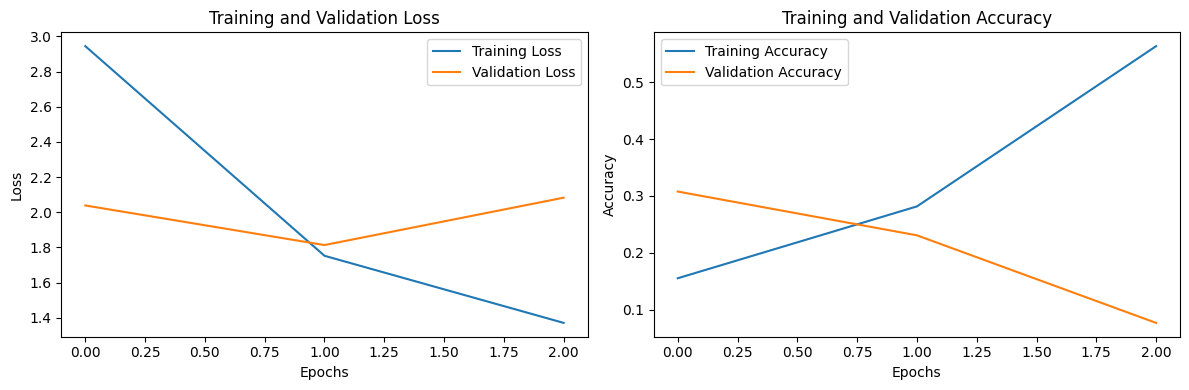

In [12]:
# Define a CNN model
class CNN(nn.Module):
    def __init__(self, num_classes):
        super(CNN, self).__init__()
        self.conv1 = nn.Conv1d(in_channels=2049, out_channels=128, kernel_size=5)
        self.relu = nn.ReLU()
        self.pool = nn.MaxPool1d(kernel_size=5)

        # Calculate the size after conv and pooling
        sequence_length = 42  # Adjusted based on the input shape
        conv_seq_length = sequence_length - 4  # kernel_size - 1 for Conv1d
        pooled_seq_length = conv_seq_length // 5  # assuming default stride for MaxPool1d

        self.flattened_size = 128 * pooled_seq_length  # 128 is the out_channels from conv1
        self.fc1 = nn.Linear(self.flattened_size, 64)
        self.fc2 = nn.Linear(64, num_classes)

    def forward(self, x):
        print(f"Input shape: {x.shape}")
        x = self.conv1(x)
        print(f"After conv1 shape: {x.shape}")
        x = self.relu(x)
        x = self.pool(x)
        print(f"After pooling shape: {x.shape}")

        x = x.view(x.size(0), -1)
        print(f"After flattening shape: {x.shape}")
        x = self.fc1(x)
        print(f"After fc1 shape: {x.shape}")
        x = self.fc2(x)
        print(f"Output shape: {x.shape}")
        return x

# Instantiate the model, define loss function and optimizer
# model = CNN().to(device)
model = CNN(num_classes=len(label_to_int)).to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)



# Convert training data to PyTorch tensors and create DataLoader
# train_data = TensorDataset(torch.stack(train_features), torch.tensor(train_labels))
# train_loader = DataLoader(train_data, batch_size=32, shuffle=True)

val_data = pd.DataFrame(dataset['validation'])
val_data = val_data.rename(columns={'label': 'label', 'statement': 'statement'})
val_data['statement'] = val_data['statement'].apply(lambda x: x.translate(str.maketrans('', '', string.punctuation)))
val_data_sampled = val_data.sample(frac=0.01, random_state=1)
val_features = [generate_features(statement, device) for statement in val_data_sampled['statement']]
# Handle labels that might not be in the label_to_int dictionary
val_labels = [label_to_int.get(label, -1) for label in val_data_sampled['label']]

# Find the maximum length across both training and validation features
max_length_train = max([feature.shape[0] for feature in train_features])
max_length_val = max([feature.shape[0] for feature in val_features])
max_length = max(max_length_train, max_length_val)

# Pad the training and validation features to the same max_length
padded_train_features = [torch.nn.functional.pad(feature, (0, 0, 0, max_length - feature.size(0))) for feature in train_features]
padded_val_features = [torch.nn.functional.pad(feature, (0, 0, 0, max_length - feature.size(0))) for feature in val_features]

# Convert the list of padded features to tensors
padded_train_features_tensor = torch.stack(padded_train_features)
padded_val_features_tensor = torch.stack(padded_val_features)

# Create TensorDatasets and DataLoaders
train_labels_tensor = torch.tensor(train_labels, dtype=torch.long, device=device)
train_dataset = TensorDataset(padded_train_features_tensor, train_labels_tensor)
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)

val_labels_tensor = torch.tensor(val_labels, dtype=torch.long, device=device)
val_dataset = TensorDataset(padded_val_features_tensor, val_labels_tensor)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=True)


train_losses, val_losses = [], []
train_accuracies, val_accuracies = [], []

epochs = 3

for epoch in range(epochs):
    model.train()
    total_loss = 0
    correct = 0
    total = 0
    for inputs, labels in tqdm(train_loader, desc=f'Epoch {epoch+1}/{epochs} - Training'):
        inputs, labels = inputs.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = model(inputs.transpose(1, 2))
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        total_loss += loss.item()
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

    train_losses.append(total_loss / len(train_loader))
    train_accuracies.append(correct / total)

    # Validation loop with progress bar
    model.eval()
    total_loss = 0
    correct = 0
    total = 0
    with torch.no_grad():
        # Wrap the val_loader with tqdm for a progress bar
        for inputs, labels in tqdm(val_loader, desc=f'Epoch {epoch+1}/{epochs} - Validation'):
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs.transpose(1, 2))
            loss = criterion(outputs, labels)
            total_loss += loss.item()
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    val_losses.append(total_loss / len(val_loader))
    val_accuracies.append(correct / total)

    print(f"Epoch {epoch+1}/{epochs}, Train Loss: {train_losses[-1]:.4f}, Train Accuracy: {train_accuracies[-1]:.4f}, Val Loss: {val_losses[-1]:.4f}, Val Accuracy: {val_accuracies[-1]:.4f}")


######### Test dataset ############
test_data = pd.DataFrame(dataset['test'])
test_data = test_data.rename(columns={'label': 'label', 'statement': 'statement'})
test_data['statement'] = test_data['statement'].apply(lambda x: x.translate(str.maketrans('', '', string.punctuation)))
test_data_sampled = test_data.sample(frac=0.01, random_state=1)
test_features = [generate_features(statement, device) for statement in test_data_sampled['statement']]
# Handle labels that might not be in the label_to_int dictionary
test_labels = [label_to_int.get(label, -1) for label in test_data_sampled['label']]

# Pad the test feature vectors to the same max_length
padded_test_features = [torch.nn.functional.pad(feature, (0, 0, 0, max_length - feature.size(0))) for feature in test_features]

# Convert the list of padded features to a tensor
padded_test_features_tensor = torch.stack(padded_test_features)

# Convert test labels to a tensor
test_labels_tensor = torch.tensor(test_labels, dtype=torch.long, device=device)

# Create a TensorDataset and DataLoader for the test set
test_dataset = TensorDataset(padded_test_features_tensor, test_labels_tensor)
test_loader = DataLoader(test_dataset, batch_size=32)


# Evaluate the model on the test data
model.eval()
test_loss = 0.0
correct_preds = 0
total_preds = 0

with torch.no_grad():
    for inputs, labels in test_loader:
        outputs = model(inputs.transpose(1, 2))
        loss = criterion(outputs, labels)
        test_loss += loss.item()
        _, predicted = torch.max(outputs.data, 1)
        correct_preds += (predicted == labels).sum().item()
        total_preds += labels.size(0)

test_loss /= len(test_loader)
test_acc = correct_preds / total_preds

print(f"Test loss: {test_loss:.3f}.. Test accuracy: {test_acc:.3f}")

plt.figure(figsize=(12, 4))

plt.subplot(1, 2, 1)
plt.plot(train_losses, label='Training Loss')
plt.plot(val_losses, label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(train_accuracies, label='Training Accuracy')
plt.plot(val_accuracies, label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.tight_layout()
plt.show()

In [ ]:
!nvidia-smi

Epoch 1/3 - Training:   0%|          | 0/1 [00:00<?, ?it/s] <br>
Input shape: torch.Size([10, 2049, 42]) <br>
After conv1 shape: torch.Size([10, 128, 38]) <br>
After pooling shape: torch.Size([10, 128, 7]) <br>
After flattening shape: torch.Size([10, 896]) <br>
After fc1 shape: torch.Size([10, 64]) <br>
Output shape: torch.Size([10, 5]) <br>
Epoch 1/3 - Training: 100%|██████████| 1/1 [00:00<00:00,  1.97it/s] <br>
Epoch 1/3 - Validation:   0%|          | 0/1 [00:00<?, ?it/s] <br> Input shape: torch.Size([10, 2049, 42]) <br>
After conv1 shape: torch.Size([10, 128, 38]) <br>
After pooling shape: torch.Size([10, 128, 7]) <br>
After flattening shape: torch.Size([10, 896]) <br>
After fc1 shape: torch.Size([10, 64]) <br>
Output shape: torch.Size([10, 5]) <br>